In [3]:
import requests
from bs4 import BeautifulSoup
from time import sleep
import pandas as pd
import os
from urllib import parse
import numpy as np
import pymysql.cursors

#대중 리뷰
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

네이버 영화 메인 페이지 1~10위 영화 상세페이지 주소 가져오기

In [4]:
def step1_get_detail_url() :
    # 접속할 페이지의 주소
    site = 'https://movie.naver.com/movie/running/current.nhn?order=reserve'

    # 접속한다.
    response = requests.get(site)   

    bs = BeautifulSoup(response.content, 'html.parser')
    #print(bs)

    # a 태그들을 가져온다.
    a_list = bs.select('.top_thumb_lst a')

    # href 속성을 가져온다.
    df = pd.DataFrame()
    for idx in range(10) :       # 상위 20개만 가져오기
        href = a_list[idx].get('href')
        
        # 가져온 href 속성의 주소를 분석한 객체를 생성한다.
        a1 = parse.urlparse(href)
        
        # 주소를 분석한 객체서 쿼리 스트링을 가져온다
        query_str = parse.parse_qs(a1.query)
        
        # 추출한 쿼리스트링 데이터에서 원하는 파라미터 데이터를 추출한다.
        code = query_str['code'][0]
        

        # print(href)
        df = df.append([[code]], ignore_index=True)

    df.columns = ['code']
    return df
#     df.to_csv('movie_code_list.csv', index=False, encoding='utf-8-sig')
#     print('주소 저장 완료')

In [5]:
df=step1_get_detail_url()

In [6]:
from operator import eq
str1 = ' '
str2= ' '
str2.strip()


''

평점 더보기 주소 스크랩

In [7]:
def step2_get_reple_href(code_frame) :
    # 스크랩한 영화 코드를 불러온다.
    code_list = code_frame['code'].tolist()

    # 테스트용
 #   code_list = ['156464', '109906']


    # 영화코드와 주소를 합쳐서 요청할 주소를 만든다.
    url_list = pd.DataFrame()
    for code in code_list:
        site = 'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=%s&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false' % code
        # print(site)
        url_list = url_list.append([[site]], ignore_index=True)

    url_list.columns = ['url']
#     url_list.to_csv('movie_url_list.csv', index=False, encoding='utf-8-sig')
    return url_list

In [8]:
url_list=step2_get_reple_href(df)

예매순 1~10 영화의 1페이지부터 마지막페이지 까지 순회하면서 평점과 리뷰 데이터 가져와서 저장

In [9]:
from operator import eq

def step3_get_reply_data(df) :
    # csv에 저장되어 있는 url 데이터를 가져온다.
    url_list = df['url'].tolist()
    i=1 #영화 순위 카운팅
    result_df = pd.DataFrame()
    
    for url in url_list :
        print(url)
        # 해당 영화의 첫 페이지 html 데이터를 가져온다. (총 몇건의 리뷰가 있는지 확인해서 "페이지수"를 계산하기 위함)
        response = requests.get(url)
        bs = BeautifulSoup(response.content, 'html.parser')
        # print(bs)

        # 총 페이지 수를 구한다.
        strong = bs.select('.total em')
        #1->0
        score_total = int(strong[0].text.replace(',', ''))    # 쉼표 없애기 / int(정수형)로 만들기
        # print(score_total)
        pageCnt = score_total // 10     # 한페이지당 10개의 리뷰가 있어서
        if score_total % 10 > 0 :
            pageCnt += 1
        print(pageCnt)

        # 전체 페이지를 돌면서 140평 데이터를 가져온다.
        # 현재 페이지
#         now_page = 1
        now_page = 1
        pageCnt = 5        # 테스트로 5페이지까지만
        
        while now_page <= pageCnt :
            #sleep(1)
            #sleep(0.0001)
            # 요청할 페이지의 주소
            url2 = url + '&page=' + str(now_page)
            # print(url2)

            # 140자평 데이터를 추출한다.
            response2 = requests.get(url2)
            bs2 = BeautifulSoup(response2.content, 'html.parser')

            

            # li 태그들을 가져온다.(score_reple 태그-리뷰-를 포함하고 있는)
            lis = bs2.select('.score_result li')

            for obj in lis :
                
                # 평점
                star_score = obj.select('.star_score em')[0].text
                
                # 140자평
                score_reple = obj.select('.score_reple p')[0].text
                score_reple = score_reple.strip() # 추가
                # 아이디
                reviewer = obj.select('.score_reple span')[-1].text
                reviewer = reviewer.strip() # 추가
                
                if eq(score_reple,reviewer ):
                    continue
#                 eq(score_reple,reviewer)

#                 print(score_reple==reviewer)
                
                    
                # 날짜
                date = obj.select('.score_reple em')[-2].text
                
#                 date = obj.select('.score_reple')[0].text
#                 print(star_score)
#                 print(score_reple)
#                 print(reviewer)
                
#                 print(len(score_reple))
#                 print(len(reviewer))
#                 print(type(score_reple))
#                 print(type(reviewer))
#                 print(date)

                # 저장한다.
                result_df = result_df.append([[score_reple, star_score, reviewer, date, i]], ignore_index=True)
#                 result_df = result_df.append([[score_reple, star_score,reviewer, date, i]], ignore_index=True)
#             result_df.columns = ['text', 'score','reviewer', 'date', 'movie_id']
#             print(result_df)

#             if os.path.exists('star_score.csv') == False :     # 아직 파일이 없으면 파일을 만든다.
#                 result_df.columns = ['text', 'score']
#                 result_df.to_csv('star_score.csv', index=False, encoding='utf-8-sig')
#             else :                                               # 이미 파일이 있으면 결과를 더한다.
#                 result_df.to_csv('star_score.csv', index=False, encoding='utf-8-sig', mode='a', header=False)
                
            print("%d / %d" % (now_page, pageCnt))               # 진행경과를 보여준다. n번째 중 몇 번째 진행중인지.
            now_page += 1
        i=i+1 #movie_id 값 1증가
    result_df.columns = ['text', 'score','reviewer', 'date', 'movie_id']
    print('저장완료')
    return result_df

In [10]:
df=step3_get_reply_data(url_list)


https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=160437&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false
47
1 / 5
2 / 5
3 / 5
4 / 5
5 / 5
https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=193804&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false
53
1 / 5
2 / 5
3 / 5
4 / 5
5 / 5
https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=106360&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false
1456
1 / 5
2 / 5
3 / 5
4 / 5
5 / 5
https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=185285&type=after&isActualPointWriteExecute=false&isMileageSubscriptionAlready=false&isMileageSubscriptionReject=false
25
1 / 5
2 / 5
3 / 5
4 / 5
5 / 5
https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code=192623&type=after&isActualPointWriteExecute=false&isMileageSubscriptio

In [11]:
df.head(10)

,text,score,reviewer,date,movie_id
0,롤러코스터는 대기할 때 가장 쫄리고 언더워터는 그냥 계속 쫄린다,10,곽민주(reds****),2020.05.27 11:05,1
1,여름에 바다못갈듯..,10,손승현(tmdg****),2020.05.27 11:02,1
2,아니이거재밌는데 평점 왜이리낮냐 ㅡㅡ,8,안농(andr****),2020.05.28 20:11,1
3,스토리는 뛰어나지 않지만 스릴러 하나는 잘 챙긴듯. 지루할 틈 없이 전개되는 점이 ...,10,굿라이프(dudg****),2020.05.27 15:19,1
4,토끼인형 생존력 오지네요,8,Aldol(brte****),2020.05.30 16:57,1
5,예고편에 속았습니다.진짜 너무 무서워 ㅠㅠ 강추할게요중간에 도망치고 싶었음 ㅠㅠ 숨...,10,광(spa2****),2020.05.27 16:50,1
6,재미없는건 아닌데...결말이 아쉽다,8,U 현(rhdb****),2020.05.27 12:56,1
7,완전 스릴넘쳐요 심장 터지는줄 ㅠㅠ,10,신지유(skg1****),2020.05.28 20:44,1
8,빠른 전개와 고립된 공간에서 느끼는 긴장감. 결말 또한 독특했다.,8,AA(yong****),2020.05.27 10:41,1
9,스포일러가 포함된 감상평입니다. 감상평 보기\n\r\n\t\t\t\t\t\t\t\t...,8,Masakuni(masa****),2020.05.27 12:45,1


In [12]:
def prepro(df): 
    df.columns = ["리뷰","평점","작성자","날짜","movie_id"]

    df['리뷰']=df['리뷰'].str.replace(pat='관람객', repl='', regex=False)
    df[df['리뷰'].str.contains("스포일러가 포함된 감상평입니다. 감상평 보기")]= np.nan #nan으로 변경
    df['리뷰']= df['리뷰'].str.strip()  # 앞 뒤 공백을 제거
    df['작성자']= df['작성자'].str.strip()  # 앞 뒤 공백을 제거

    df=df.replace('',np.NaN)
    result=df.dropna()    
#     df.dropna()
    final_result=result.reset_index(drop=True)
    return final_result

In [13]:
df= prepro(df)

In [14]:
df.head(50)

,리뷰,평점,작성자,날짜,movie_id
0,롤러코스터는 대기할 때 가장 쫄리고 언더워터는 그냥 계속 쫄린다,10,곽민주(reds****),2020.05.27 11:05,1.0
1,여름에 바다못갈듯..,10,손승현(tmdg****),2020.05.27 11:02,1.0
2,아니이거재밌는데 평점 왜이리낮냐 ㅡㅡ,8,안농(andr****),2020.05.28 20:11,1.0
3,스토리는 뛰어나지 않지만 스릴러 하나는 잘 챙긴듯. 지루할 틈 없이 전개되는 점이 ...,10,굿라이프(dudg****),2020.05.27 15:19,1.0
4,토끼인형 생존력 오지네요,8,Aldol(brte****),2020.05.30 16:57,1.0
5,예고편에 속았습니다.진짜 너무 무서워 ㅠㅠ 강추할게요중간에 도망치고 싶었음 ㅠㅠ 숨...,10,광(spa2****),2020.05.27 16:50,1.0
6,재미없는건 아닌데...결말이 아쉽다,8,U 현(rhdb****),2020.05.27 12:56,1.0
7,완전 스릴넘쳐요 심장 터지는줄 ㅠㅠ,10,신지유(skg1****),2020.05.28 20:44,1.0
8,빠른 전개와 고립된 공간에서 느끼는 긴장감. 결말 또한 독특했다.,8,AA(yong****),2020.05.27 10:41,1.0
9,작년에개봉했던 47미터나 크롤보다 도 더 스릴있고 으스스했음. 그러니까 그냥 해저판...,10,신짱아(hhho****),2020.05.30 00:24,1.0


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import pickle
from konlpy.tag import *

In [22]:
# 형태소 분석을 위한 함수
def tokenizer(text) :
    okt = Okt()
    return okt.morphs(text)

In [23]:
df.head(50)

,리뷰,평점,작성자,날짜,movie_id
0,롤러코스터는 대기할 때 가장 쫄리고 언더워터는 그냥 계속 쫄린다,10,곽민주(reds****),2020.05.27 11:05,1.0
1,여름에 바다못갈듯..,10,손승현(tmdg****),2020.05.27 11:02,1.0
2,아니이거재밌는데 평점 왜이리낮냐 ㅡㅡ,8,안농(andr****),2020.05.28 20:11,1.0
3,스토리는 뛰어나지 않지만 스릴러 하나는 잘 챙긴듯. 지루할 틈 없이 전개되는 점이 ...,10,굿라이프(dudg****),2020.05.27 15:19,1.0
4,토끼인형 생존력 오지네요,8,Aldol(brte****),2020.05.30 16:57,1.0
5,예고편에 속았습니다.진짜 너무 무서워 ㅠㅠ 강추할게요중간에 도망치고 싶었음 ㅠㅠ 숨...,10,광(spa2****),2020.05.27 16:50,1.0
6,재미없는건 아닌데...결말이 아쉽다,8,U 현(rhdb****),2020.05.27 12:56,1.0
7,완전 스릴넘쳐요 심장 터지는줄 ㅠㅠ,10,신지유(skg1****),2020.05.28 20:44,1.0
8,빠른 전개와 고립된 공간에서 느끼는 긴장감. 결말 또한 독특했다.,8,AA(yong****),2020.05.27 10:41,1.0
9,작년에개봉했던 47미터나 크롤보다 도 더 스릴있고 으스스했음. 그러니까 그냥 해저판...,10,신짱아(hhho****),2020.05.30 00:24,1.0


In [24]:
def step7_insert_review(df) :
    # 객체를 복원한다.
    with open('pipe.dat', 'rb') as fp:
        pipe = pickle.load(fp)

    import numpy as np
    import pandas as pd
    
    
    rlist=df["리뷰"].tolist()
    df=df.drop("리뷰",axis=1) 
    df_result = pd.DataFrame()
    
    for i in rlist :
        text = i

        str = [text]
        # 예측 정확도
        r1 = np.max(pipe.predict_proba(str) * 100)
        # 예측 결과
        r2 = pipe.predict(str)[0]

        if r2 == '1' :
            print(text)
            
            print('긍정적인 리뷰')
            df_result = df_result.append([[text, r1, r2]],ignore_index=True)
            print('----------------------------')
        else :
            print(text)
            print('부정적인 리뷰')
            df_result = df_result.append([[text, r1, r2]],ignore_index=True)
            print('----------------------------')

        print('정확도 : %.3f' % r1)
    
    df_result.columns = ['리뷰','정확도','결과']
    final_result=pd.concat([df_result,df],axis=1)
    return final_result


In [25]:
final_result = step7_insert_review(df)

C:\Users\IIS3\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\IIS3\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\IIS3\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\IIS3\anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator Pipeline from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at y

롤러코스터는 대기할 때 가장 쫄리고 언더워터는 그냥 계속 쫄린다
긍정적인 리뷰
----------------------------
정확도 : 96.147
여름에 바다못갈듯..
긍정적인 리뷰
----------------------------
정확도 : 89.556
아니이거재밌는데 평점 왜이리낮냐 ㅡㅡ
부정적인 리뷰
----------------------------
정확도 : 92.444
스토리는 뛰어나지 않지만 스릴러 하나는 잘 챙긴듯. 지루할 틈 없이 전개되는 점이 좋고 크리스틴 연기는 갈수록 빛난다. 믿고 배우는 배우!!
긍정적인 리뷰
----------------------------
정확도 : 94.441
토끼인형 생존력 오지네요
긍정적인 리뷰
----------------------------
정확도 : 88.992
예고편에 속았습니다.진짜 너무 무서워 ㅠㅠ 강추할게요중간에 도망치고 싶었음 ㅠㅠ 숨막힐정도로 무서움
긍정적인 리뷰
----------------------------
정확도 : 97.972
재미없는건 아닌데...결말이 아쉽다
긍정적인 리뷰
----------------------------
정확도 : 92.866
완전 스릴넘쳐요 심장 터지는줄 ㅠㅠ
긍정적인 리뷰
----------------------------
정확도 : 98.635
빠른 전개와 고립된 공간에서 느끼는 긴장감. 결말 또한 독특했다.
긍정적인 리뷰
----------------------------
정확도 : 96.204
작년에개봉했던 47미터나 크롤보다 도 더 스릴있고 으스스했음. 그러니까 그냥 해저판에이리언 으로 보시면 될듯. 아무튼 최근 개봉하는영화들중 볼만함 ㅇㅇ
긍정적인 리뷰
----------------------------
정확도 : 94.267
기대 안하고 봤는데 생각보다 재밌어요 계속 여운이 남는 명작느낌은 없지만 돈 아깝진 않아요~
긍정적인 리뷰
----------------------------
정확도 : 99.204
심해의 공포를 잘 표현해냄.. 초

정적인 플롯이라고 생각했는데 생각보다 긴장감 넘치고 몰입됨. 재밌음
긍정적인 리뷰
----------------------------
정확도 : 98.709
내용도 재미있고 특히 실화라는게 ㅋㅋ임팩트 있었습니다
긍정적인 리뷰
----------------------------
정확도 : 95.266
극장에서 봐야하는 영화 was the best !:)
긍정적인 리뷰
----------------------------
정확도 : 99.302
그들이 웃고나서야 참았던 긴장이 풀렸다
긍정적인 리뷰
----------------------------
정확도 : 98.417
몰입도가 좋아서 재미있게 잘봤습니다~
긍정적인 리뷰
----------------------------
정확도 : 99.546
해리포터 드디어 해리포터이미지가 없어지는 영화였다. 연기 정말 환상적
긍정적인 리뷰
----------------------------
정확도 : 98.291
영화 보면서 평점 처음 남겨요 진짜... 너무 재미있었습니다 영화를 보기 전 평점을 보고 갔음에도 처음부터 끝까지 심장 쫄깃함이 이어지고 영상미 진짜 몰입할 수 있게 만든 감독... 상 줘야 돼요 너무 재미있게 봤습...
긍정적인 리뷰
----------------------------
정확도 : 97.596
긴장감이 말이 필요없어요 꼭 보세요 간만에 인생영화 등극
긍정적인 리뷰
----------------------------
정확도 : 99.989
말이 필요없음. 이런걸 영화라고 함.
긍정적인 리뷰
----------------------------
정확도 : 93.296
레미제라블이후로 휴잭맨의인생영화였다
긍정적인 리뷰
----------------------------
정확도 : 99.925
휴잭맨의. 매력이 한껏 돋보인 영화입니다.다른 출연자들도 너무 멋지구요.사람은 누구나 소중하며, 현재를 멋지게 사는게 중요하다는 메세지도 있구요.좋았습니다
긍정적인 리뷰
----------------------------

옆에 남편이랑 같이 보는데 옛날 젊은 시절 남편이 그립고 왜 그리 눈물이 나던지 ..
긍정적인 리뷰
----------------------------
정확도 : 98.372
이게 왜 9.65인지,, 개연성이 부족하고 감동 포인트가 없어요. 소재만 참신.
부정적인 리뷰
----------------------------
정확도 : 84.402
아무생각 없이 보기엔 나쁘지 않은거 같습니다. 정말로 아무 생각없이요. 생각을 하는 순간부턴 불편한 순간들이 많은 영화인거 같습니다.  우선 이 영화가 왜 15세인지 모르겠습니다. 성인은 저로썬 상관없었지만 요즘 시...
긍정적인 리뷰
----------------------------
정확도 : 98.120
포스터와 영상미는 잘 뽑았지만 보는 내내 아무것도 이해 할 수 없었던 난해한 작품. 술, 담배, 섹스 없이는 스토리를 진행하지 못한다. 무슨 메세지를 주고자 하는건지 조금은 알겠으나 그 메세지 조차 공감할 수 없다....
긍정적인 리뷰
----------------------------
정확도 : 94.495
전반적으로 괜찮은데 앙투안이 설득력이 너무 떨어짐 그냥 미친놈 같고
긍정적인 리뷰
----------------------------
정확도 : 62.261
컨셉도 신선하고 영화 좋았어요
긍정적인 리뷰
----------------------------
정확도 : 94.789
프랑스 썅송판 부부의 세계
긍정적인 리뷰
----------------------------
정확도 : 93.166
어제 시사회에서 보고 아직 빠져있는중! 인생영화 등극! 컨셉도 좋지만 여운이 남는 감동.. 힐링되는 기분! 강강추
긍정적인 리뷰
----------------------------
정확도 : 99.753
이런 시간여행 영화라면 언제든지 반갑다!! 우리 나라에서 리메이크 되었으면! 더 공감 잘되도 추억에도 빠져들고 재밌을 것 같은데! 리메이크 원츄!!
긍정적인 리뷰
----------------------------
정확도 :

자신의 언니 상대로 쀼의 세계 벌인 애들엄마, 17살에 안전 조치도 없이 남자와 불장난한 딸내미, 역시 피는 못속이는 건너집 엿보기 관음증 큰아들내미, 불륜 결과물로 태어난 자폐증 막내아들, 도대체 누굴 쏘고 싶은건...
긍정적인 리뷰
----------------------------
정확도 : 80.981
공포물의 단순한 연출 공식을 사용하지만, 오버하지 않고, 배우들의 캐릭터가 탄탄하며, 나름 철학적인 주제의식도 빠지지 않는다. 앞으로 스페인 공포 영화 덕질 하련다 ㅎㅎ.
긍정적인 리뷰
----------------------------
정확도 : 98.897
어거지스러운 놀라는 장면의 연속
긍정적인 리뷰
----------------------------
정확도 : 92.447
그냥 그랬음! 무서운거 좋아하는 사람은 안무서움!반전이 있어서 좋았다.연기는 굿!
긍정적인 리뷰
----------------------------
정확도 : 99.350
어디선가 많이 본 것같은 배우분들 :) 아역배우너무생긴게귀여움..
긍정적인 리뷰
----------------------------
정확도 : 96.750
감독새끼 찾으러 갈사람 구합니다깝툭튀만 많고 연출은 그닥이에요저 같은 상남자는 하품 하면서 봤어요..
긍정적인 리뷰
----------------------------
정확도 : 85.141
소리만 개큼 짱큼 왕큼 헐랭 대박 진짜?
긍정적인 리뷰
----------------------------
정확도 : 81.040
귀신보다 융자가 더무섭다나였으면 귀신 뚜까패고 다음날 출근준비했다
긍정적인 리뷰
----------------------------
정확도 : 84.574
양심이 있으면 댓글알바 하지마세요
부정적인 리뷰
----------------------------
정확도 : 83.628
기대안했는데 생각보다 재밌었어요 스토리가있어서 무서웠지만 끝까지봤네요
긍정적인 리뷰
----------------------------
정확도 : 96.040
나쁘지않

----------------------------
정확도 : 98.743
좋았어요. 배우 대뷔한 김은영(치타) 님의 연기도 생각보다 자연스럽고 좋아서 놀랐구, 스크린에서 많이 보이는 (얼굴은 아는데 이름은 모르는) 배우분들도 많이 나와서 놀랐습니다! 무엇보다 과하게 가공된 느낌이 아닌 자...
긍정적인 리뷰
----------------------------
정확도 : 95.982
이것저것 재지말고 그냥 봐 재미있어
긍정적인 리뷰
----------------------------
정확도 : 84.869
한표형 돌아왔구나!!! 너무멋있다
긍정적인 리뷰
----------------------------
정확도 : 95.130
노래할때 머싯는 언니네
긍정적인 리뷰
----------------------------
정확도 : 95.140
영화를 보면이태원을 한번도 안가본 사람으로  써 이태원이  화려하지만은 안타를 늦기며  빠저서  보다나왔다.
긍정적인 리뷰
----------------------------
정확도 : 87.052
기대 없이 보았다가.. 정말 빠져들었어요!믿고 보는 조민수 배우님 그리고 연기하는 치타도 너무 매력 철철 ㅠㅠ 여러분 제발 이 영화 극장에서 봐주세요 ㅠㅠ
긍정적인 리뷰
----------------------------
정확도 : 99.457
오늘 처음 개봉한줄도 모르고 아무 기대없이 보고왔는데 태어나서 처음으로 평점 써봅니다 영상미 하며 병맛 개그, 좋은 음악, 다양한 캐릭터들, 배우들 연기력 하며 다 종합선물세트같은 영화였습니다~ 주는 메세지도 좋고 ...
긍정적인 리뷰
----------------------------
정확도 : 98.333
독립영화가 이렇게 볼거리 많고 잼 날줄은..귀호강까지~♡
긍정적인 리뷰
----------------------------
정확도 : 95.678
치타연기 너무 좋았어요.내용도 반전있고 찡했어요.추천합니다^^
긍정적인 리뷰
----------------------------
정확도 : 

영화본후엔 세상 다 산거같은 느낌들어서 싫지만 또 언젠가 찾아보겠지
긍정적인 리뷰
----------------------------
정확도 : 98.347
이 영화는 세계문화유산으로 지정되어야 합니다
긍정적인 리뷰
----------------------------
정확도 : 95.993
주샨만이 데이를 이해해준 영화
긍정적인 리뷰
----------------------------
정확도 : 95.140
내가 태어나서 본 영화 중 가장 아름답다
긍정적인 리뷰
----------------------------
정확도 : 97.106
동양 최고의 명작, 지루하지 않습니다
긍정적인 리뷰
----------------------------
정확도 : 99.793
데이가 곧 장국영이었고 장국영이 곧 데이였다.
긍정적인 리뷰
----------------------------
정확도 : 99.696
장국영과 함께 영화팬들 가슴속에 영원히 기억될 영화.
긍정적인 리뷰
----------------------------
정확도 : 99.757
난 본디 사내아이로 계집아이도 아닌데
긍정적인 리뷰
----------------------------
정확도 : 96.346
장국영의 위엄ㄷㄷ
긍정적인 리뷰
----------------------------
정확도 : 98.435
10점으로도 부족하다. 명작이다. 첸카이거 감독의 다른 영화들도 보고 싶어졌다. 물론, 장국영과 장풍의, 공리 또한 대단했다.
긍정적인 리뷰
----------------------------
정확도 : 99.597
영화를 다 감상하고 난 후 머리가 어지럽고 정신이 아득하다. 영화 보는 내내 화면에서 눈을 뗄 수 없다. 영화에 감사하다.
긍정적인 리뷰
----------------------------
정확도 : 97.170
한편의 영화이상의 가치를 지닌 영화.... 영화라고 하기엔 그 영향이 너무나 크다.
긍정적인 리뷰
----------------------------
정확도 : 98.470
희노

In [26]:
final_result  #1 긍정, 0 부정

,리뷰,정확도,결과,평점,작성자,날짜,movie_id
0,롤러코스터는 대기할 때 가장 쫄리고 언더워터는 그냥 계속 쫄린다,96.147405,1,10,곽민주(reds****),2020.05.27 11:05,1.0
1,여름에 바다못갈듯..,89.555557,1,10,손승현(tmdg****),2020.05.27 11:02,1.0
2,아니이거재밌는데 평점 왜이리낮냐 ㅡㅡ,92.443972,0,8,안농(andr****),2020.05.28 20:11,1.0
3,스토리는 뛰어나지 않지만 스릴러 하나는 잘 챙긴듯. 지루할 틈 없이 전개되는 점이 ...,94.441486,1,10,굿라이프(dudg****),2020.05.27 15:19,1.0
4,토끼인형 생존력 오지네요,88.991632,1,8,Aldol(brte****),2020.05.30 16:57,1.0
...,...,...,...,...,...,...,...
473,귀가 즐겁고 귀여운 트롤들이 너무 좋았어요!,99.816865,1,10,마그네타(gjdb****),2020.04.29 17:59,10.0
474,웬디가 더빙을 정말 생각보다 너무 잘해서 깜짝놀랐음 ㅜㅜㅠ 노래는 말할것도 없고.....,94.814906,1,10,고갱(hy00****),2020.04.30 11:29,10.0
475,1편안봤는데 트롤들이 너무 귀엽고 신나요! 락트롤이 젤 신나는것이..ㅋㅋㅋ 재즈트롤...,98.134428,1,10,애플민트(appl****),2020.04.29 17:08,10.0
476,웬디가 더빙을 너무 잘했어요! 스토리도 재미있었습니다!,99.378559,1,10,진하늘(snit****),2020.04.30 11:30,10.0


대중적인 리뷰 시작
--------------------------------------

In [37]:
import sister

In [38]:
sentence_embedding = sister.MeanEmbedding(lang="file",fasttextfile="cc.ko.100.bin")

TypeError: __init__() got an unexpected keyword argument 'fasttextfile'

In [22]:
final_result['clustering']=0

In [23]:
final_result

,리뷰,정확도,결과,평점,작성자,날짜,movie_id,clustering
0,롤러코스터는 대기할 때 가장 쫄리고 언더워터는 그냥 계속 쫄린다,96.147405,1,10,곽민주(reds****),2020.05.27 11:05,1.0,0
1,여름에 바다못갈듯..,89.555557,1,10,손승현(tmdg****),2020.05.27 11:02,1.0,0
2,스토리는 뛰어나지 않지만 스릴러 하나는 잘 챙긴듯. 지루할 틈 없이 전개되는 점이 ...,94.441486,1,10,굿라이프(dudg****),2020.05.27 15:19,1.0,0
3,예고편에 속았습니다.진짜 너무 무서워 ㅠㅠ 강추할게요중간에 도망치고 싶었음 ㅠㅠ 숨...,97.972388,1,10,광(spa2****),2020.05.27 16:50,1.0,0
4,완전 스릴넘쳐요 심장 터지는줄 ㅠㅠ,98.635494,1,10,신지유(skg1****),2020.05.28 20:44,1.0,0
...,...,...,...,...,...,...,...,...
474,귀가 즐겁고 귀여운 트롤들이 너무 좋았어요!,99.816865,1,10,마그네타(gjdb****),2020.04.29 17:59,10.0,0
475,웬디가 더빙을 정말 생각보다 너무 잘해서 깜짝놀랐음 ㅜㅜㅠ 노래는 말할것도 없고.....,94.814906,1,10,고갱(hy00****),2020.04.30 11:29,10.0,0
476,1편안봤는데 트롤들이 너무 귀엽고 신나요! 락트롤이 젤 신나는것이..ㅋㅋㅋ 재즈트롤...,98.134428,1,10,애플민트(appl****),2020.04.29 17:08,10.0,0
477,웬디가 더빙을 너무 잘했어요! 스토리도 재미있었습니다!,99.378559,1,10,진하늘(snit****),2020.04.30 11:30,10.0,0


In [24]:
def review_embedding(df): #각 영화 리뷰를 100차원의 값으로 임베딩
    review_list=df['리뷰'].tolist()
    vector1_list = []
    for i in range(len(review_list)): 
    
        s1 = sentence_embedding(review_list[i])
        vector1_list.append(s1)
        
    vector_df= pd.DataFrame(vector1_list) #DataFrame으로
    return vector_df #merge

In [25]:
def model(X):
    ifor = IsolationForest(n_estimators=100, max_samples=512,contamination=0.0235).fit(X) #모델 생성  
    return ifor

In [26]:
def index(score,value): #Outlit score 최소인 20개 리뷰 확인
    index = []
    score=score.tolist()
    for j in range(10): #10개 추출
        find_index=score.index(value[j])
        index.append(find_index)
    return index

In [27]:
def labeling(df,ind):
    for x in ind:
        df['clustering'][x]=1
    return df

In [28]:
def separ(df):
    a = list()
    
    mv_1 = df['movie_id'] == 1
    mv1 = df[mv_1]
    
    mv_2 = df['movie_id'] == 2
    mv2 = df[mv_2]
    mv2.reset_index(drop=True, inplace=True)
    
    mv_3 = df['movie_id'] == 3
    mv3 = df[mv_3]
    mv3.reset_index(drop=True, inplace=True)
    
    mv_4 = df['movie_id'] == 4
    mv4 = df[mv_4]
    mv4.reset_index(drop=True, inplace=True)
    
    mv_5 = df['movie_id'] == 5
    mv5 = df[mv_5]
    mv5.reset_index(drop=True, inplace=True)
    
    mv_6 = df['movie_id'] == 6
    mv6 = df[mv_6]
    mv6.reset_index(drop=True, inplace=True)
    
    mv_7 = df['movie_id'] == 7
    mv7 = df[mv_7]
    mv7.reset_index(drop=True, inplace=True)
    
    mv_8 = df['movie_id'] == 8
    mv8 = df[mv_8]
    mv8.reset_index(drop=True, inplace=True)
    
    mv_9 = df['movie_id'] == 9
    mv9 = df[mv_9]
    mv9.reset_index(drop=True, inplace=True)
    
    mv_10 = df['movie_id'] == 10
    mv10 = df[mv_10]
    mv10.reset_index(drop=True, inplace=True)
    
    a.append([mv1,mv2,mv3,mv4,mv5,mv6,mv7,mv8,mv9,mv10])
    return a
    

In [29]:
def d_scatter(scores_f):
    for i in range(10):
            plt.scatter(scores_f[i],1,color='red',marker='*') #scores_f 값을 *으로 마킹. 시각화

In [30]:
def outlier_comp(data):
#     c_data= concat(data)
    ifor=model(data)
    scores_f= -ifor.decision_function(data)
    d_scatter(scores_f)
    return scores_f

In [31]:
def min_score(score): #outlier score 최소인 10개 값 추출
    hi=score.tolist()
    hi.sort()
    a=hi[:10]
    return a

In [32]:
def total_embedding(mv_list):
    vector_list=list()
    
    for i in range(10): #영화개수 10개
        vec= review_embedding(mv_list[0][i])
        score_s=outlier_comp(vec)
        min_value=min_score(score_s)
        ind = index(score_s, min_value)
        for x in ind:
            mv_list[0][i]['clustering'][x]=1
    
    return mv_list


In [33]:
def top_review(score,value,review): #Outlit score 최소인 20개 리뷰 확인
    index = []
    top20_review=[]
    score=score.tolist()
    for i in range(len(value)):
        index.append(score.index(value[i]))
    
    for ind in index:
        top20_review.append(review[ind])
        
    return top20_review

In [34]:
def df_to_list(df):
    review=df['리뷰'].tolist()
    accuracy=df['정확도'].tolist()
    result=df['결과'].tolist()
    # score=final_result['평점'].tolist()
    reviewer=df['작성자'].tolist()
    date=df['날짜'].tolist()
    movie_id=df['movie_id'].tolist()
    clustering=df['clustering'].tolist()
    return review, accuracy, result, reviewer, date, movie_id, clustering

In [47]:
def db_connect(final_result):
    review, accuracy, result, reviewer, date, movie_id, clustering = df_to_list(final_result)

    conn = pymysql.connect( #DB연결
    host='localhost',
    user='root',
    password='dpdltm137',
    db='movie_review',
    charset='utf8' 
    )
    total = len(review) #리뷰 개수
    curs = conn.cursor()
    
    ###############################
    sql_del = "delete from reviews"
    curs.execute(sql_del)
    conn.commit()
    print("테이블 전체 삭제")
    ###############################
    
    
    sql = "insert into reviews(review_id, review_movie_id, review_contents, review_accuracy, review_result, review_reviewer, review_date, review_clustering) values(%s,%s,%s,%s,%s,%s,%s,%s)"
    for i in range(total):
        print("%d / %d" % (i, total))
        curs.execute(sql, (i+1 ,movie_id[i], review[i], accuracy[i], result[i], reviewer[i], date[i], clustering[i]))
        print('ok')    
        conn.commit()

In [48]:
mv_list=separ(final_result)

C:\Users\IIS3\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\IIS3\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:274: UserWarning: max_samples (512) is greater than the total number of samples (46). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))
C:\Users\IIS3\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\IIS3\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to 

C:\Users\IIS3\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\IIS3\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\IIS3\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\I

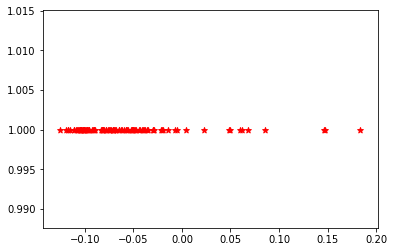

In [49]:
real_final_result=total_embedding(mv_list)

In [50]:
final_df=pd.concat([real_final_result[0][0],real_final_result[0][1],real_final_result[0][2],
                   real_final_result[0][3],real_final_result[0][4],real_final_result[0][5],
                   real_final_result[0][6],real_final_result[0][7],real_final_result[0][8],
                   real_final_result[0][9],],ignore_index=True)

In [51]:
final_df

,리뷰,정확도,결과,평점,작성자,날짜,movie_id,clustering
0,롤러코스터는 대기할 때 가장 쫄리고 언더워터는 그냥 계속 쫄린다,96.147405,1,10,곽민주(reds****),2020.05.27 11:05,1.0,0
1,여름에 바다못갈듯..,89.555557,1,10,손승현(tmdg****),2020.05.27 11:02,1.0,0
2,스토리는 뛰어나지 않지만 스릴러 하나는 잘 챙긴듯. 지루할 틈 없이 전개되는 점이 ...,94.441486,1,10,굿라이프(dudg****),2020.05.27 15:19,1.0,0
3,예고편에 속았습니다.진짜 너무 무서워 ㅠㅠ 강추할게요중간에 도망치고 싶었음 ㅠㅠ 숨...,97.972388,1,10,광(spa2****),2020.05.27 16:50,1.0,0
4,완전 스릴넘쳐요 심장 터지는줄 ㅠㅠ,98.635494,1,10,신지유(skg1****),2020.05.28 20:44,1.0,0
...,...,...,...,...,...,...,...,...
474,귀가 즐겁고 귀여운 트롤들이 너무 좋았어요!,99.816865,1,10,마그네타(gjdb****),2020.04.29 17:59,10.0,0
475,웬디가 더빙을 정말 생각보다 너무 잘해서 깜짝놀랐음 ㅜㅜㅠ 노래는 말할것도 없고.....,94.814906,1,10,고갱(hy00****),2020.04.30 11:29,10.0,1
476,1편안봤는데 트롤들이 너무 귀엽고 신나요! 락트롤이 젤 신나는것이..ㅋㅋㅋ 재즈트롤...,98.134428,1,10,애플민트(appl****),2020.04.29 17:08,10.0,1
477,웬디가 더빙을 너무 잘했어요! 스토리도 재미있었습니다!,99.378559,1,10,진하늘(snit****),2020.04.30 11:30,10.0,0


In [52]:
db_connect(final_df)

테이블 전체 삭제
0 / 479
ok
1 / 479
ok
2 / 479
ok
3 / 479
ok
4 / 479
ok
5 / 479
ok
6 / 479
ok
7 / 479
ok
8 / 479
ok
9 / 479
ok
10 / 479
ok
11 / 479
ok
12 / 479
ok
13 / 479
ok
14 / 479
ok
15 / 479
ok
16 / 479
ok
17 / 479
ok
18 / 479
ok
19 / 479
ok
20 / 479
ok
21 / 479
ok
22 / 479
ok
23 / 479
ok
24 / 479
ok
25 / 479
ok
26 / 479
ok
27 / 479
ok
28 / 479
ok
29 / 479
ok
30 / 479
ok
31 / 479
ok
32 / 479
ok
33 / 479
ok
34 / 479
ok
35 / 479
ok
36 / 479
ok
37 / 479
ok
38 / 479
ok
39 / 479
ok
40 / 479
ok
41 / 479
ok
42 / 479
ok
43 / 479
ok
44 / 479
ok
45 / 479
ok
46 / 479
ok
47 / 479
ok
48 / 479
ok
49 / 479
ok
50 / 479
ok
51 / 479
ok
52 / 479
ok
53 / 479
ok
54 / 479
ok
55 / 479
ok
56 / 479
ok
57 / 479
ok
58 / 479
ok
59 / 479
ok
60 / 479
ok
61 / 479
ok
62 / 479
ok
63 / 479
ok
64 / 479
ok
65 / 479
ok
66 / 479
ok
67 / 479
ok
68 / 479
ok
69 / 479
ok
70 / 479
ok
71 / 479
ok
72 / 479
ok
73 / 479
ok
74 / 479
ok
75 / 479
ok
76 / 479
ok
77 / 479
ok
78 / 479
ok
79 / 479
ok
80 / 479
ok
81 / 479
ok
82 / 479
ok
83 /